# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** Not properly dealing with cyclical features

**Reference:** http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/model_selection/tips_and_tricks/tips_and_tricks.ipynb<br>

<br></font>
</div>

# How to deal with cyclical features

<div class="alert alert-block alert-info">
<font color=black><br>

- Hours, days, week, months in a year and wind directions are all example of features that are cyclical.
- **It is important** to convert these into representation that can **preserve information** such as hour 23 and hour 0 should be close to each other.

<br></font>
</div>

# Example: converting hours of the day

<div class="alert alert-block alert-info">
<font color=black><br>

- Consider the hours of the day
- The best way to handle this is to calculate the sin and cos component so that we represent our cyclical feature as (x,y) coordinates of a circle. 
- In this representation hour, 23 and hour 0 are right next to each other numerically, just as they should be.
- So we have **preserved** information

<br></font>
</div>

# Import modules

In [20]:
import os
import numpy as np
import pandas as pd
import warnings
from subprocess import call
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Import dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- What we did for the hours of the data is called **feature engineering**
- We can explore this with the bike sharing dataset to see if it actually improves the performance of the model
- The goal is to predict how many bikes are being used at an given hour

<br></font>
</div>

In [12]:
data_dir = '../DATASETS/bike_sharing'
if not os.path.isdir(data_dir):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
    call('curl -O ' + url, shell=True)
    call('mkdir ' + data_dir, shell=True)
    call('unzip Bike-Sharing-Dataset.zip -d ' + data_dir, shell=True)

In [13]:
data_path = os.path.join(data_dir, 'hour.csv')
df = pd.read_csv(data_path)
print('dimension:', df.shape)
df.head()

dimension: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


<div class="alert alert-block alert-info">
<font color=black><br>

- There are a bunch of features in here that are likely valuable to predict cnt, the count of users riding bikes (the sum of "casual" riders and "registered" riders). 
- Here we'll just focus on the cyclical features: mnth (month) and hr (hour).
- **REMEMBER:** The **claim** is that the transformed features should improve the performance of our model, let's give it a shot.

<br></font>
</div>

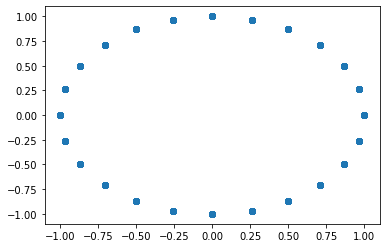

In [16]:
# Now instead of hours ranging from 0 to 23,
# we have two new features "hr_sin" and "hr_cos" which
# each ranges from 0 to 1, and we'll use these two features
# as inputs to our model as oppose to the raw form
hour_col = 'hr'
df['hr_sin'] = np.sin(df[hour_col] * (2. * np.pi / 24))
df['hr_cos'] = np.cos(df[hour_col] * (2. * np.pi / 24))

month_col = 'mnth'
df['mnth_sin'] = np.sin((df[month_col] - 1) * (2. * np.pi / 12))
df['mnth_cos'] = np.cos((df[month_col] - 1) * (2. * np.pi / 12))

plt.scatter(df['hr_sin'], df['hr_cos'])
plt.show()

In [22]:
# model pipeline
standardize = StandardScaler()
linear = LinearRegression()
pipeline = Pipeline([
    ('standardize', standardize),
    ('linear', linear)])

# input features and labels
label_col = 'cnt'
input_cols = ['mnth', 'hr']
y = df[label_col].values
X = df[input_cols].astype(np.float64)

# sklearn's LinearRegression may give harmless errors
# https://github.com/scipy/scipy/issues/5998
warnings.filterwarnings(
    action='ignore', module='scipy', message='^internal gelsd')

cv = 10
scoring = 'neg_mean_squared_error'
results = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
print('CV Scoring Result: mean =', np.mean(results), 'std =', np.std(results))

CV Scoring Result: mean = -29904.664260591177 std = 14327.111793459853


In [23]:
input_cols = ['mnth_sin', 'mnth_cos', 'hr_sin', 'hr_cos']
X = df[input_cols].values

# negative mean squared error, the closer the value is to 0, the better
results = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
print('CV Scoring Result: mean =', np.mean(results), 'std =', np.std(results))

CV Scoring Result: mean = -21968.675852049608 std = 9965.803743174423


# Conclusion

<div class="alert alert-block alert-danger">
<font color=black><br>

- Feature engineering: transform the month and hour feature into a more representative form
- This has improved the model performance

<br></font>
</div>